## Exploring WindFarmNetwork: Key Methods and Usage

This notebook demonstrates how to use the key methods of the `WindFarmNetwork` class from the `optiwindnet` package.

We will:
- Create a simple wind farm network
- Use heuristic and MILP optimization
- Explore key methods such as:
  - `.optimize()`
  - `.plot()`
  - `.cost()`, `.length()`
  - `.terse_links()`, `.update_from_terse_links()`
  - `.gradient()`
  - `.get_network()`

> **Note:** Many of the Jupyter notebooks provided include SVG figures as output. To ensure these visuals are displayed correctly in JupyterLab or Jupyter Notebook, make sure the notebook is marked as **trusted**.
> *In JupyterLab, you can do this by pressing* `Ctrl + Shift + C` *and selecting* **Trust Notebook**.

Import required modules

In [1]:
import numpy as np
from optiwindnet.api import WindFarmNetwork, EWRouter, MILPRouter, ModelOptions

In [2]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

## Create a WindFarmNetwork Instance
We start with dummy coordinates for 5 turbines and 1 substation, and define a simple cable type.


In [3]:
turbinesC = np.array([[0, 0], [1, 1], [2, 0], [3, 1], [4, 0]])
substationsC = np.array([[2, -2]])
cables = [(10, 5.0)]

wfn = WindFarmNetwork(
    cables=cables,
    turbinesC=turbinesC,
    substationsC=substationsC
)


### Method: `optimize(router=...)`

This is the main method that computes the electrical network based on a given routing algorithm (heuristic, metaheuristic or MILP).
 > Note that the router could be passed directly to `WindFarmNetwork(router=...)`.

<Axes: >

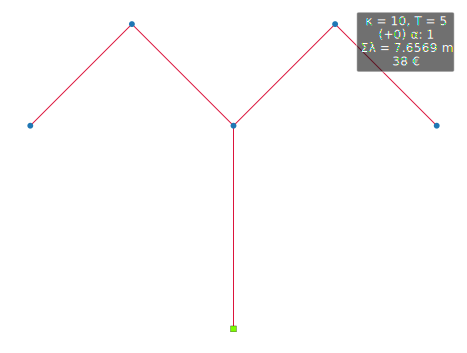

In [4]:
## Use a heuristic router (Esau-Williams)
wfn.optimize(router=EWRouter())
wfn.plot()

#### Use a MILP router with full control over topology and feeders

The solution from the previous call to `wfn.optimize()` is stored within the `wfn` object.
If this solution is **feasible under the current MILP settings**, it will be **automatically used as a warm start**.
Otherwise, if it does not meet the current `ModelOptions` constraints, it will be **ignored**, and the MILP solver will start from scratch.



    - branched structure not allowed under "radial" topology



<Axes: >

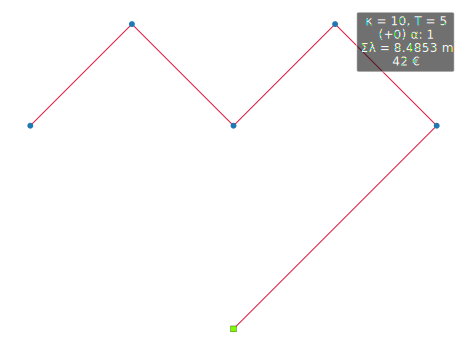

In [5]:
model_opts = ModelOptions(topology='radial', feeder_limit='minimum', feeder_route='straight')
wfn.optimize(router=MILPRouter(solver_name='ortools', time_limit=2, mip_gap=0.01, model_options=model_opts), verbose=True)
wfn.plot()

### Method: `plot()` and Variants

These methods help you visualize the layout at different stages:

- `plot_location()` – turbine/substation coordinates and border
- `plot()` – final optimized layout

> For a detailed explanation of this method see [Plotting Notebook](api_05_Plotting.ipynb).


<Axes: >

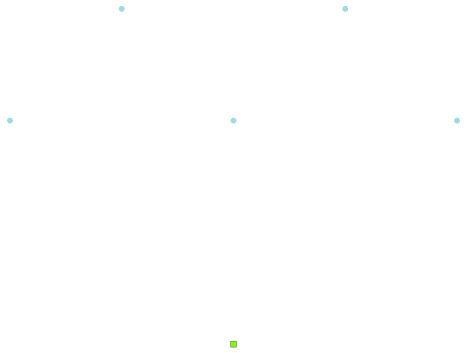

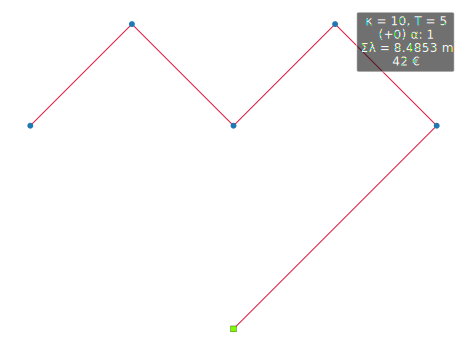

In [6]:
wfn.plot_location()
wfn.plot()

### Method: `cost()` and `length()`

Returns the total cost and cable length of the optimized network.

In [7]:
print("Network cost:", wfn.cost())
print("Network length:", wfn.length())

Network cost: 42.42640687119285
Network length: 8.485281374238571


### Method: `terse_links()` and `update_from_terse_links()`

A terse link is a compact way to describe how each turbine is connected in the electrical network. It’s just a list (or array) where:

* Each position `i` represents turbine `i`

* The value at position `i` is the node that turbine `i` connects to
(this could be another turbine or a substation)

Hence:

- `terse_links()` gives a compact array of link targets (integer representation).
- `update_from_terse_links()` allows you to reconstruct the network from this array, optionally updating coordinates.

In [8]:
terse = wfn.terse_links()
print("Terse link array:", terse)

Terse link array: [ 1  2  3  4 -1]


### wfn.update_from_terse_links()

This method assumes a **valid and feasible network**, so it’s your responsibility to ensure that:
- The connections form a proper **feeder tree**
- Every turbine is (indirectly or directly) connected to a **substation**
- Capacity constraints are not violated

Suppose you have a wind farm with:
- **5 turbines** → nodes `0, 1, 2, 3, 4`
- **1 substation** → node `-1` (*Note: In optiwindnet, substations are assigned negative indices*)

We want the following connections:
- Turbine 0 → Substation (-1)
- Turbine 1 → Turbine 0
- Turbine 2 → Substation (-1)
- Turbine 3 → Turbine 2
- Turbine 4 → Turbine 3

This gives us the `terse_links` array:

```python
terse_links = [-1, 0, -1, 2, 3]


<Axes: >

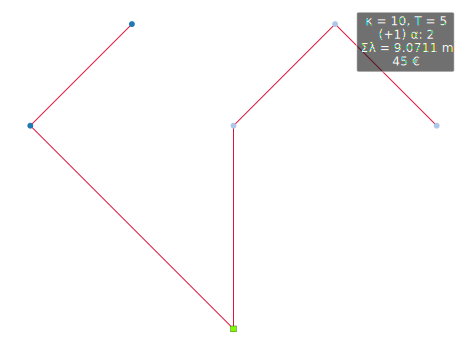

In [9]:
new_terse_links = np.array([-1, 0, -1, 2, 3])

# Apply the new configuration
wfn.update_from_terse_links(new_terse_links)

# Visualize the updated layout
wfn.plot()


### Method: `gradient()`

This method computes the gradient of the cost or length with respect to turbine/substation positions.
Useful for hybrid optimization or sensitivity analysis.
 > Note: default of `gradient_type` is `length`.

In [10]:
print('gradient_type=length\n')
grad_turb, grad_subs = wfn.gradient()
print("Gradient (w.r.t. turbines):\n", grad_turb)
print("Gradient (w.r.t. substations):\n", grad_subs)

print('\n ------------- \n')
print('gradient_type=length\n')
grad_turb, grad_subs = wfn.gradient(gradient_type='cost')
print("Gradient (w.r.t. turbines):\n", grad_turb)
print("Gradient (w.r.t. substations):\n", grad_subs)

gradient_type=length

Gradient (w.r.t. turbines):
 [[-1.41421356  0.        ]
 [ 0.70710678  0.70710678]
 [-0.70710678  0.29289322]
 [ 0.          1.41421356]
 [ 0.70710678 -0.70710678]]
Gradient (w.r.t. substations):
 [[ 0.70710678 -1.70710678]]

 ------------- 

gradient_type=length

Gradient (w.r.t. turbines):
 [[-7.07106781  0.        ]
 [ 3.53553391  3.53553391]
 [-3.53553391  1.46446609]
 [ 0.          7.07106781]
 [ 3.53553391 -3.53553391]]
Gradient (w.r.t. substations):
 [[ 3.53553391 -8.53553391]]


### Method: `get_network()`

This method returns the **final optimized network** as a **structured NumPy array**, where each row represents an edge in the network.

Each edge includes detailed attributes such as:

* **`src`**: index of the source node
* **`tgt`**: index of the target (destination node)
* **`length`**: physical cable length
* **`load`**: electrical load carried through the cable (number of turbines)
* **`cable`**: index of the cable type used (e.g., 0 for first type in cable list)
* **`cost`**: cost associated with that cable

In [11]:
network_data = wfn.get_network()
network_data[:2]  # Preview first few edges

array([(0,  1, 1.41421356, 1., False, 0,  7.07106781),
       (0, -1, 2.82842712, 2., False, 0, 14.14213562)],
      dtype=[('src', '<i8'), ('tgt', '<i8'), ('length', '<f8'), ('load', '<f8'), ('reverse', '?'), ('cable', '<i8'), ('cost', '<f8')])

## ✅ Summary

We explored the most useful methods of the `WindFarmNetwork` class:

| Method | Purpose |
|--------|---------|
| `optimize()` | Run optimization with a router |
| `plot()` | Visualize the network |
| `cost()`, `length()` | Get total cost and length |
| `terse_links()` | Get compact link encoding |
| `update_from_terse_links()` | Apply terse links manually |
| `gradient()` | Compute layout gradient |
| `get_network()` | Export the final network data |


For deeper insights into individual methods, refer to the dedicated notebooks provided.
